In [1]:
import numpy as np
import pandas as pd
from scipy.io import mmread
import matplotlib.pyplot as plt
from tifffile import imread
import os
from scipy.stats import zscore
from sklearn.metrics import pairwise_distances
from scipy.optimize import linear_sum_assignment
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm
import seaborn as sns
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [2]:
# marker names for immune, tumor, and their overlap
immune_markers = ['DNA_1','CD3', 'PDL1', 'GRZB','Ki67', 'PanCK', 'CD45','CD68', 'CD3d', 'CD8a',
             'CD163', 'aSMA', 'CD14','CD4', 'FOXP3', 'PDL1_2','CD11b', 'pRB', 'PD1',
             'LaminABC', 'PDL1_3', 'LAG3','CD20', 'HLA_A', 'MHC_II_DPB1']
tumor_markers = ['DNA_1','CD3', 'pERK', 'Rad51','CCND1', 'Vimentin', 'aSMA','Ecad', 'ER', 'PR',
            'EGFR', 'pRB', 'HER2','Ki67', 'CD45', 'p21','CK14','CK19', 'CK17',
            'LaminABC', 'AR', 'H2Ax','PCNA','PanCK', 'CD31']
shared_markers = ['DNA_1','CD3','aSMA','pRB','PanCK','CD45','Ki67','LaminABC']

In [3]:
def ids_to_table(ids, table):
    match_table = table[table['CellID'].isin(ids)] # get relevant rows
    df1 = match_table.set_index('CellID')
    match_table = df1.reindex(ids) # set new table in correct order
    return match_table

def get_correlations(markers, immune_table, tumor_table):
    correlations = []
    for i,s in enumerate(markers):
        correlations.append(spearmanr(immune_table[s],tumor_table[s])[0])
    return correlations

In [4]:
cores = ['A10','A5','A6','A8','B10','B1','B3','B4',
         'B6','B7','B9','C10','C1','D11','D2','D8',
         'E10','E3','E5','E6','E8','E9','F11','F1','F2','F7',
         'G11','G1','G3','G7','G9','H10',
         'H2','H3','H4','H6','H7','H8','H9']
cpath = '/home/groups/ChangLab/heussner/tma-integration/data/nuc_cell_tables'
#tracking_results = []
correlation_results = []
frac = []
for core in cores:
    corr_tracking = pd.read_csv(f'/home/groups/ChangLab/heussner/tma-integration/results/Cell_tracking_correlation/{core}.csv')
    tumor_all = pd.read_csv(os.path.join(cpath,f'{core}_tCyCIF_tumor_both.csv'))
    immune_all = pd.read_csv(os.path.join(cpath,f'{core}_tCyCIF_immune_both.csv'))
    corr_tracking = corr_tracking[corr_tracking['tumor_id']>0]
    imtbl = ids_to_table(corr_tracking['immune_id'],immune_all)
    tmtbl = ids_to_table(corr_tracking['tumor_id'],tumor_all)
    correlation_results.append(get_correlations(shared_markers, imtbl,tmtbl))
    frac.append(len(corr_tracking)/len(immune_all))
marker_correlations = np.array(correlation_results)

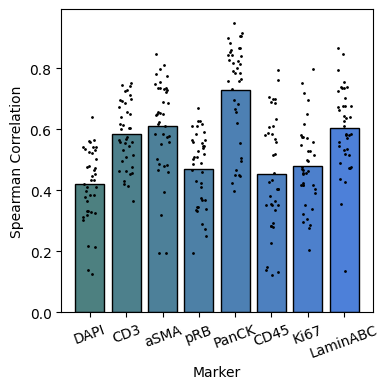

In [15]:
plt.figure(figsize=(4,4))
for i, m in enumerate(shared_markers):
    plt.bar(i, np.mean(marker_correlations,axis=0)[i], color=(0.3,.5,.5+.05*i),zorder=2,edgecolor='black')
    plt.scatter([i+np.random.randint(-20,20)/100 for k in range(len(cores))],marker_correlations[:,i],color='black',s=1,zorder=3)
plt.xticks([i for i in range(len(shared_markers))], shared_markers,rotation=20)
plt.xlabel('Marker')
plt.ylabel('Spearman Correlation')
plt.tight_layout()
plt.savefig('Supp_Fig2.png',dpi=600)
plt.show()

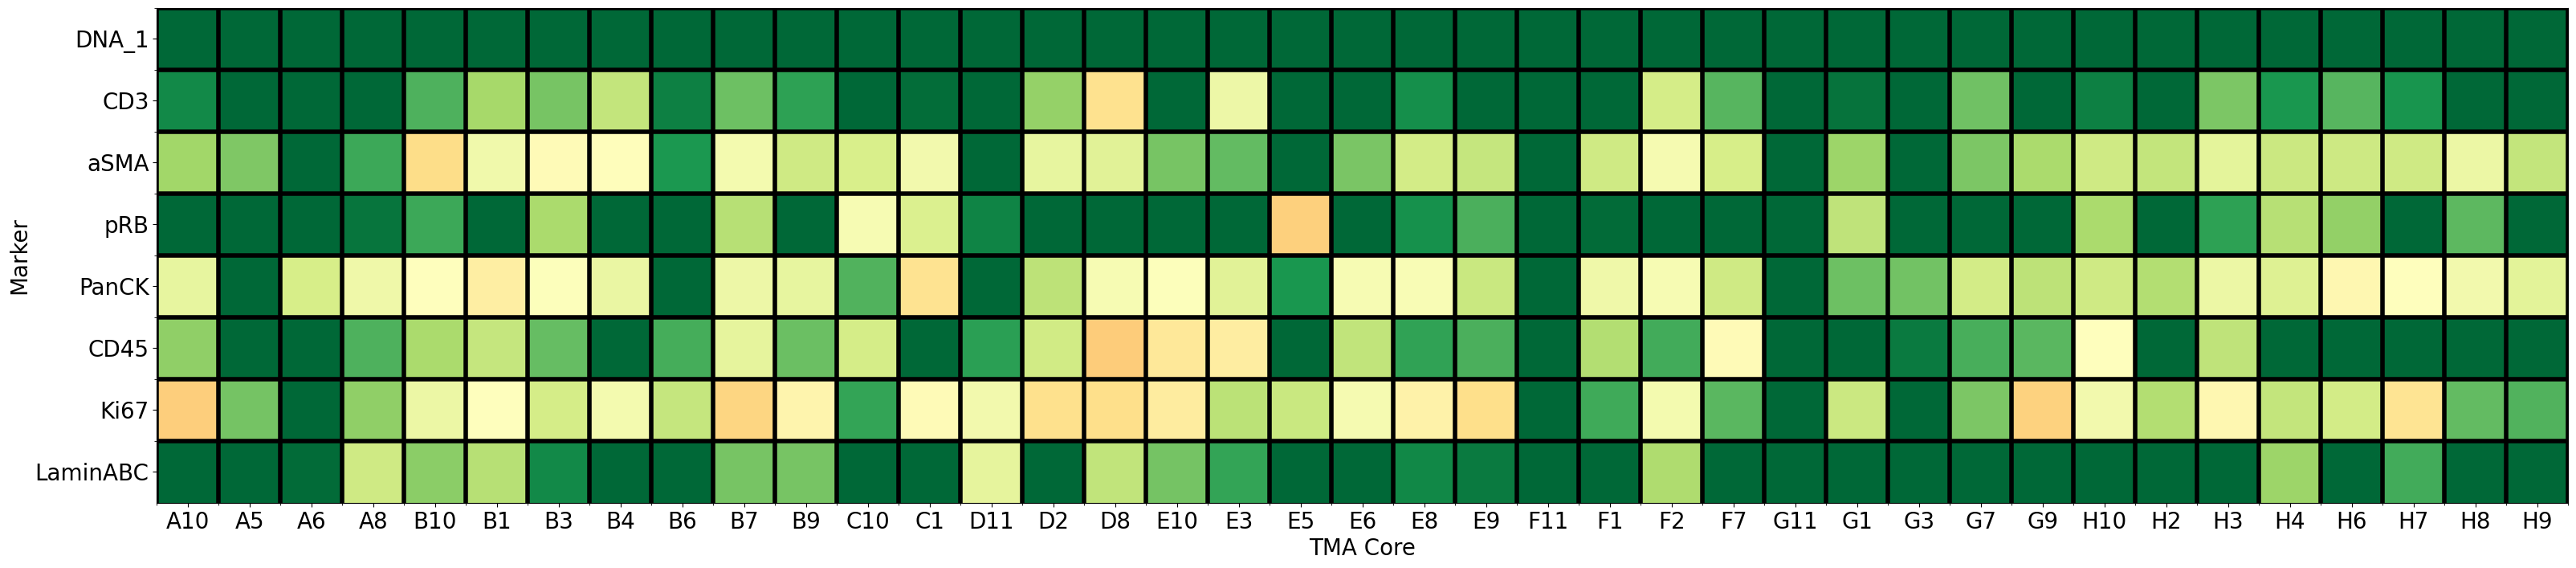

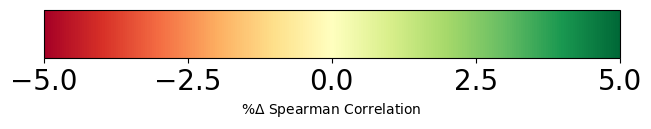

In [5]:
# load results:
cores = ['A10','A5','A6','A8','B10','B1','B3','B4',
         'B6','B7','B9','C10','C1','D11','D2','D8',
         'E10','E3','E5','E6','E8','E9','F11','F1','F2','F7',
         'G11','G1','G3','G7','G9','H10',
         'H2','H3','H4','H6','H7','H8','H9']

cpath = '/home/groups/ChangLab/heussner/tma-integration/data/nuc_cell_tables'
tracking_results = []
correlation_results = []
radius_results = []
for core in cores:
    corr_tracking = pd.read_csv(f'/home/groups/ChangLab/heussner/tma-integration/results/Cell_tracking_correlation/{core}.csv')
    corr_tracking = corr_tracking[corr_tracking['tumor_id']>0]
    
    overlap_tracking = pd.read_csv(f'/home/groups/ChangLab/heussner/tma-integration/results/Cell_tracking/{core}.csv')
    overlap_tracking = overlap_tracking[overlap_tracking['tumor_id']>0]
    
    radius_linear = pd.read_csv(f'/home/groups/ChangLab/heussner/tma-integration/results/Linear_assignment_radius/{core}.csv')
    radius_linear = radius_linear[radius_linear['tumor_id']>0]
    
    tumor_all = pd.read_csv(os.path.join(cpath,f'{core}_tCyCIF_tumor_both.csv'))
    immune_all = pd.read_csv(os.path.join(cpath,f'{core}_tCyCIF_immune_both.csv'))

    # add in missing pairs
    immune_new = []
    tumor_new = []
    for i, im in enumerate(corr_tracking['immune_id']):
        if im in list(overlap_tracking['immune_id']):
            immune_new.append(im)
            tumor_new.append(corr_tracking['tumor_id'].iloc[i])
    
    for i, im in enumerate(overlap_tracking['immune_id']):
        if im not in immune_new:
            immune_new.append(im)
            tumor_new.append(overlap_tracking['tumor_id'].iloc[i])

    imtbl = ids_to_table(overlap_tracking['immune_id'],immune_all)
    tmtbl = ids_to_table(overlap_tracking['tumor_id'],tumor_all)
    tracking_results.append(get_correlations(shared_markers, imtbl,tmtbl))

    imtbl = ids_to_table(immune_new,immune_all)
    tmtbl = ids_to_table(tumor_new,tumor_all)
    correlation_results.append(get_correlations(shared_markers, imtbl,tmtbl))

    imtbl = ids_to_table(radius_linear['immune_id'],immune_all)
    tmtbl = ids_to_table(radius_linear['tumor_id'],tumor_all)
    radius_results.append(get_correlations(shared_markers, imtbl,tmtbl))

cr = np.array(correlation_results)
tr = np.array(tracking_results)
r = np.array(radius_results)

norm = (cr - tr)/tr * 100

plt.figure(figsize=(norm.shape[0],norm.shape[1]))
ax = plt.gca()
cbar = ax.imshow(norm.T,vmin=-5,vmax=5,cmap='RdYlGn')
ax.set_yticks([0,1,2,3,4,5,6,7],shared_markers,fontsize=20)
ax.set_xticks([i for i in range(len(cores))],cores,fontsize=20)

# Minor ticks
ax.set_xticks(np.arange(-.5, 39, 1), minor=True)
ax.set_yticks(np.arange(-.5, 7, 1), minor=True)

ax.set_xlabel('TMA Core',fontsize=20)
ax.set_ylabel('Marker',fontsize=20)
# Gridlines based on minor ticks
ax.grid(which='minor', color='black', linestyle='-', linewidth=4)
plt.show()

fig = plt.figure()
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])
cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal',
                               norm=mpl.colors.Normalize(-5, 5),
                               ticks = [-5,-2.5,0,2.5,5],
                               label = r'%$\Delta$ Spearman Correlation',
                               cmap='RdYlGn')
cb.ax.tick_params(labelsize=20)

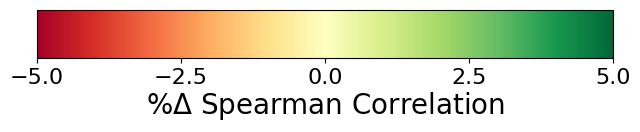

In [29]:
fig = plt.figure()
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])
cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal',
                               norm=mpl.colors.Normalize(-5, 5),
                               ticks = [-5,-2.5,0,2.5,5],
                               cmap='RdYlGn')
cb.ax.tick_params(labelsize=16)
cb.set_label(r'%$\Delta$ Spearman Correlation', labelpad=2, size=20)
plt.savefig('colorbar.png',dpi=600)
plt.show()

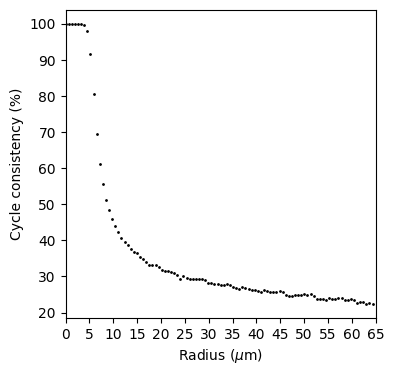

In [6]:
with open('cyclic.pkl','rb') as handle:
    results = pickle.load(handle)

rad = [i*0.65 for i in range(300)][0:100]
y = results['B3'][0][0:100]
plt.figure(figsize=(4,4))
plt.scatter(rad,[i*100 for i in y], s=1, color='black')
plt.xlabel(r'Radius ($\mu$m)')
plt.xticks([i*5 for i in range(14)])
plt.xlim([0,65])
plt.ylabel('Cycle consistency (%)')
plt.show()

/tmp/ipykernel_1661485/964897094.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


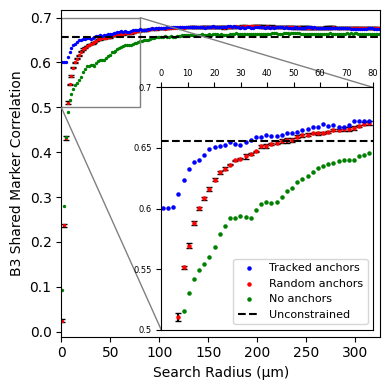

In [7]:
radii = [i*0.65 for i in range(501)][1::3]
path = '/home/groups/ChangLab/heussner/tma-integration/results/Radius_exploration'
c = 'B3'
with open(os.path.join(path,f'sla_random_spearman_{c}.pkl'),'rb') as handle:
    sla_random = np.array(pickle.load(handle))

sla_random_mean = np.mean(sla_random, axis=0)[1::3]
sla_random_std = np.std(sla_random, axis=0)[1::3]

with open(os.path.join(path,f'sla_track_spearman_{c}.pkl'),'rb') as handle:
    sla_track = pickle.load(handle)[1::3]

with open(os.path.join(path,f'sla_all_spearman_{c}.pkl'),'rb') as handle:
    sla_all = pickle.load(handle)[1::3]

with open(os.path.join(path,f'la_all_spearman_{c}.pkl'),'rb') as handle:
    no_constraints = pickle.load(handle)

fig, ax = plt.subplots(1,figsize=(4,4))
ax.scatter(radii, sla_track, color='blue', label='Tracked anchors',s=2,zorder=2)
ax.scatter(radii, sla_random_mean, color='red',label='Random anchors',s=2,zorder=1)
ax.scatter(radii, sla_all, color='green',label='No anchors',s=2)
ax.axhline(no_constraints, color='black',linestyle='--',label='Unconstrained')
ax.errorbar(radii, sla_random_mean, yerr=sla_random_std,fmt="none",ecolor='black',capsize=2,zorder=0)
ax.set_xlabel(u'Search Radius (\u03bcm)')
ax.set_ylabel(f'{c} Shared Marker Correlation')
ax.set_xticks([j*50 for j in range(7)])
ax.set_xlim([0,500*0.65])

axins = zoomed_inset_axes(ax, 2.7, loc=4)
axins.scatter(radii, sla_track, color='blue', label='Tracked anchors',s=5,zorder=2)
axins.scatter(radii, sla_random_mean, color='red',label='Random anchors',s=5,zorder=1)
axins.scatter(radii, sla_all, color='green',label='No anchors',s=5)
axins.errorbar(radii, sla_random_mean, yerr=sla_random_std,fmt="none",ecolor='black',capsize=2,zorder=0)
axins.axhline(no_constraints, color='black',linestyle='--',label='Unconstrained')
x1, x2, y1, y2 = 0, 77, 0.5, 0.7
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([i*10 for i in range(9)],[i*10 for i in range(9)],fontsize=6)
axins.xaxis.tick_top()
axins.set_yticks([np.round(.5+i*.05,2) for i in range(5)],[np.round(.5+i*.05,2) for i in range(5)],fontsize=6)

mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")
axins.legend(loc='lower right',fontsize=8)
plt.tight_layout()
plt.savefig('tracking_justification_main.svg')
plt.show()

/tmp/ipykernel_246335/1357551244.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_246335/1357551244.py:74: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


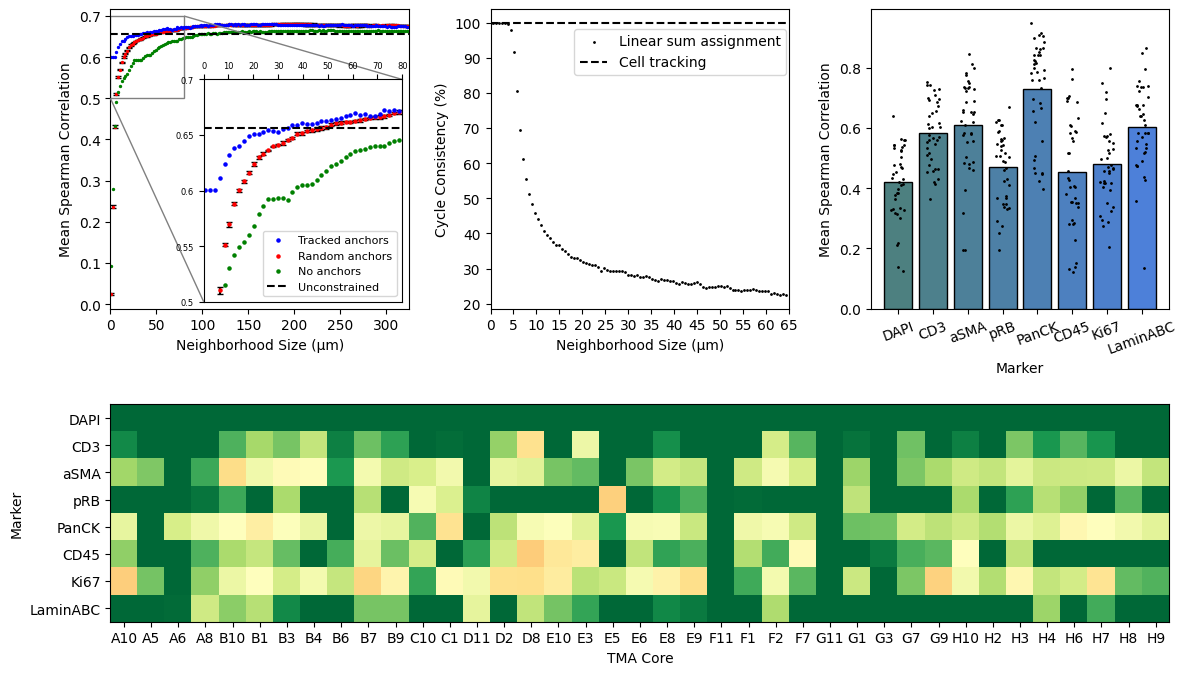

In [18]:
import matplotlib.gridspec as gridspec
shared_markers = ['DAPI','CD3','aSMA','pRB','PanCK','CD45','Ki67','LaminABC']
fig = plt.figure(figsize=(12,7),constrained_layout=True)

# create a grid spec of 2 rows and 3 columns
gs = gridspec.GridSpec(2, 3, figure=fig)

# create subplots in the first row
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# create a subplot in the second row that spans over all columns
ax4 = fig.add_subplot(gs[1, :])

#cycle consistency
ax2.scatter(rad,[i*100 for i in y], s=1, color='black',label='Linear sum assignment')
ax2.plot([0,65],[100,100],linestyle='--',color='black',label='Cell tracking')
ax2.set_xlabel(u'Neighborhood Size (\u03bcm)')
ax2.set_xticks([i*5 for i in range(14)])
ax2.set_xlim([0,65])
ax2.set_ylabel('Cycle Consistency (%)')
ax2.legend(loc =(.28,.78))

# match marker correlation
for i, m in enumerate(shared_markers):
    ax3.bar(i, np.mean(marker_correlations,axis=0)[i], color=(0.3,.5,.5+.05*i),zorder=2,edgecolor='black')
    ax3.scatter([i+np.random.randint(-20,20)/100 for k in range(len(cores))],marker_correlations[:,i],color='black',s=1,zorder=3)
ax3.set_xticks([i for i in range(len(shared_markers))], shared_markers,rotation=20)
ax3.set_xlabel('Marker')
ax3.set_ylabel('Mean Spearman Correlation')

# heatmap
ax4 = plt.gca()
cbar = ax4.imshow(norm.T,vmin=-5,vmax=5,cmap='RdYlGn')
ax4.set_yticks([0,1,2,3,4,5,6,7],shared_markers)
ax4.set_xticks([i for i in range(len(cores))],cores)

# Minor ticks
#ax4.set_xticks(np.arange(-.5, 39, 1), minor=True)
#ax4.set_yticks(np.arange(-.5, 7, 1), minor=True)

ax4.set_xlabel('TMA Core')
ax4.set_ylabel('Marker')
#ax4.grid(which='minor', color='black', linestyle='-')

# search radius exploration
ax1.scatter(radii, sla_track, color='blue', label='Tracked anchors',s=2,zorder=2)
ax1.scatter(radii, sla_random_mean, color='red',label='Random anchors',s=2,zorder=1)
ax1.scatter(radii, sla_all, color='green',label='No anchors',s=2)
ax1.axhline(no_constraints, color='black',linestyle='--',label='Unconstrained')
ax1.errorbar(radii, sla_random_mean, yerr=sla_random_std,fmt="none",ecolor='black',capsize=2,zorder=0)
ax1.set_xlabel(u'Neighborhood Size (\u03bcm)')
ax1.set_ylabel('Mean Spearman Correlation')
ax1.set_xticks([j*50 for j in range(7)])
ax1.set_xlim([0,500*0.65])

axins = zoomed_inset_axes(ax1, 2.7, loc=4)
axins.scatter(radii, sla_track, color='blue', label='Tracked anchors',s=5,zorder=2)
axins.scatter(radii, sla_random_mean, color='red',label='Random anchors',s=5,zorder=1)
axins.scatter(radii, sla_all, color='green',label='No anchors',s=5)
axins.errorbar(radii, sla_random_mean, yerr=sla_random_std,fmt="none",ecolor='black',capsize=2,zorder=0)
axins.axhline(no_constraints, color='black',linestyle='--',label='Unconstrained')
x1, x2, y1, y2 = 0, 77, 0.5, 0.7
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([i*10 for i in range(9)],[i*10 for i in range(9)],fontsize=6)
axins.xaxis.tick_top()
axins.set_yticks([np.round(.5+i*.05,2) for i in range(5)],[np.round(.5+i*.05,2) for i in range(5)],fontsize=6)

mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
axins.legend(loc='lower right',fontsize=8)

fig.tight_layout()
plt.savefig('Figure_2.png',dpi=600)
plt.show()

/tmp/ipykernel_1661485/1304491344.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_1661485/1304491344.py:74: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


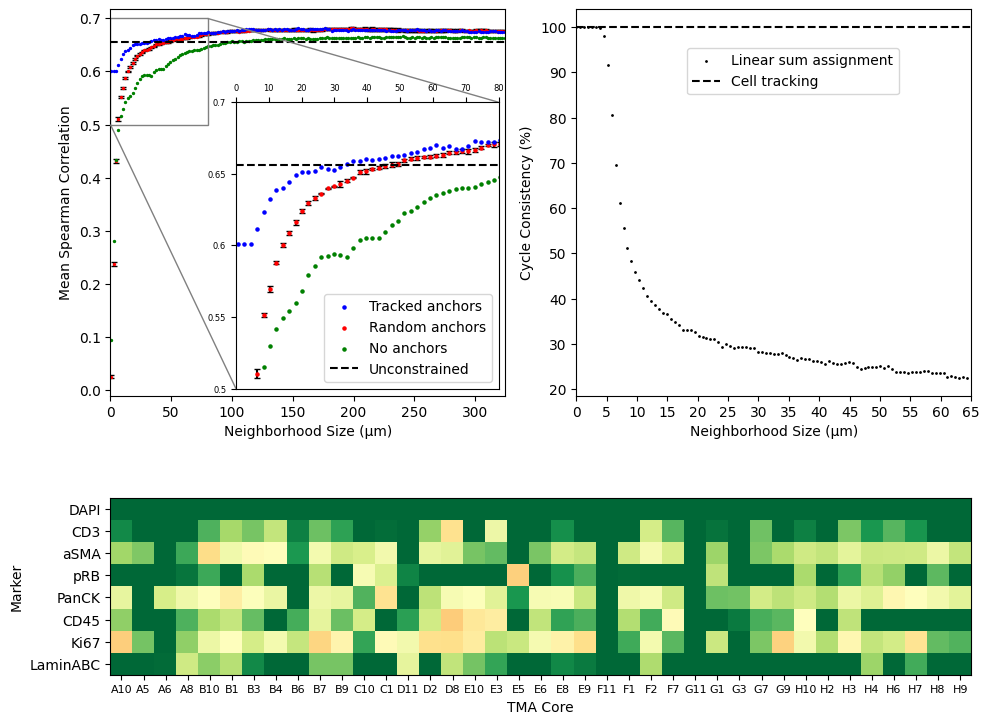

In [13]:
import matplotlib.gridspec as gridspec
shared_markers = ['DAPI','CD3','aSMA','pRB','PanCK','CD45','Ki67','LaminABC']
fig = plt.figure(figsize=(10,8),constrained_layout=True)

# create a grid spec of 2 rows and 3 columns
gs = gridspec.GridSpec(2, 2, figure=fig)

# create subplots in the first row
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
#ax3 = fig.add_subplot(gs[0, 2])

# create a subplot in the second row that spans over all columns
ax4 = fig.add_subplot(gs[1, :])

#cycle consistency
ax2.scatter(rad,[i*100 for i in y], s=1, color='black',label='Linear sum assignment')
ax2.plot([0,65],[100,100],linestyle='--',color='black',label='Cell tracking')
ax2.set_xlabel(u'Neighborhood Size (\u03bcm)')
ax2.set_xticks([i*5 for i in range(14)])
ax2.set_xlim([0,65])
ax2.set_ylabel('Cycle Consistency (%)')
ax2.legend(loc =(.28,.78))

# match marker correlation
#for i, m in enumerate(shared_markers):
#    ax3.bar(i, np.mean(marker_correlations,axis=0)[i], color=(0.3,.5,.5+.05*i),zorder=2,edgecolor='black')
#    ax3.scatter([i+np.random.randint(-20,20)/100 for k in range(len(cores))],marker_correlations[:,i],color='black',s=1,zorder=3)
#ax3.set_xticks([i for i in range(len(shared_markers))], shared_markers,rotation=20)
#ax3.set_xlabel('Marker')
#ax3.set_ylabel('Mean Spearman Correlation')

# heatmap
ax4 = plt.gca()
cbar = ax4.imshow(norm.T,vmin=-5,vmax=5,cmap='RdYlGn')
ax4.set_yticks([0,1,2,3,4,5,6,7],shared_markers)
ax4.set_xticks([i for i in range(len(cores))],cores,fontsize=8)

# Minor ticks
#ax4.set_xticks(np.arange(-.5, 39, 1), minor=True)
#ax4.set_yticks(np.arange(-.5, 7, 1), minor=True)

ax4.set_xlabel('TMA Core')
ax4.set_ylabel('Marker')
#ax4.grid(which='minor', color='black', linestyle='-')

# search radius exploration
ax1.scatter(radii, sla_track, color='blue', label='Tracked anchors',s=2,zorder=2)
ax1.scatter(radii, sla_random_mean, color='red',label='Random anchors',s=2,zorder=1)
ax1.scatter(radii, sla_all, color='green',label='No anchors',s=2)
ax1.axhline(no_constraints, color='black',linestyle='--',label='Unconstrained')
ax1.errorbar(radii, sla_random_mean, yerr=sla_random_std,fmt="none",ecolor='black',capsize=2,zorder=0)
ax1.set_xlabel(u'Neighborhood Size (\u03bcm)')
ax1.set_ylabel('Mean Spearman Correlation')
ax1.set_xticks([j*50 for j in range(7)])
ax1.set_xlim([0,500*0.65])

axins = zoomed_inset_axes(ax1, 2.7, loc=4)
axins.scatter(radii, sla_track, color='blue', label='Tracked anchors',s=5,zorder=2)
axins.scatter(radii, sla_random_mean, color='red',label='Random anchors',s=5,zorder=1)
axins.scatter(radii, sla_all, color='green',label='No anchors',s=5)
axins.errorbar(radii, sla_random_mean, yerr=sla_random_std,fmt="none",ecolor='black',capsize=2,zorder=0)
axins.axhline(no_constraints, color='black',linestyle='--',label='Unconstrained')
x1, x2, y1, y2 = 0, 77, 0.5, 0.7
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticks([i*10 for i in range(9)],[i*10 for i in range(9)],fontsize=6)
axins.xaxis.tick_top()
axins.set_yticks([np.round(.5+i*.05,2) for i in range(5)],[np.round(.5+i*.05,2) for i in range(5)],fontsize=6)

mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
axins.legend(loc='lower right')

fig.tight_layout()
plt.savefig('Figure_2.png',dpi=600)
plt.show()